### ЗАДАЧА

Необходимо провести разведовательный анализ данных и предоставить список пользователей, которые войдут в программу лояльности 


## SUMMARY:
1. Предобработала чистые данные, выделила информацию о названии бренда 


2. Посчитала общее количество товаров для каждого пользователя, на основе 75 процентиля отобрала наиболее лояльных(> 5 покупок) 


3. Определила количество уникальных брендов на каждого пользователя и количество покупок на каждый бренд 


4. Отобрала для каждого пользователя только тот бренд, товаров которого было куплено больше всего 


5. Объединила таблицы с общим количеством покупок и количеством товара на уникальный бренд для каждого пользователя 


6. Рассчитала индекс лояльности


7. Дальнейшее решение - в зависимости от продуктовой задачи( для лимитированного количества высоких скидок - можно взять только тех, у кого индекс лояльности близиться к нулю, если массовые скидки - то смотреть по процентилям 



In [234]:
#импрортируем библиотеки

import pandas as pd

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [232]:
#считываем файл csv 

df = pd.read_csv('/Users/kamilamur/Downloads/lesson_3_data_1_.csv', encoding='windows-1251')

df.head()


,Unnamed: 0,tk,pl,dia,hs,tc,cta,id_art,id_subsubfam,id_subfam,...,id_famn,id_seccion,id_subagr,id_agr,vta,uni,id_artn,art_sp,fam_sp,fam_en
0,1242,120071109002055793,1,2007/11/09,0.505729,110000761,11000076,21895,101070640100,1010706401,...,10107064,10107,101,1,0.68,1.0,21895,MARAVILLA 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
1,1243,120070601004053633,1,2007/06/01,0.588519,110000761,11000076,21816,101070640100,1010706401,...,10107064,10107,101,1,0.38,1.0,21816,FIDEO CABELLIN 500 G Store_Brand,PASTA ALIMENTICIA SE,pasta
2,1244,120070928004076410,1,2007/09/28,0.785498,28491841,2849184,562840,101070640100,1010706401,...,10107064,10107,101,1,1.55,2.0,562840,SPAGUETTI Nє 5 500 G Brand_1,PASTA ALIMENTICIA SE,pasta
3,1245,120070616003074261,1,2007/06/16,0.550961,95931501,9593150,28914,101070640100,1010706401,...,10107064,10107,101,1,1.03,2.0,28914,FIDEO FIDEUБ 500 Brand_7,PASTA ALIMENTICIA SE,pasta
4,1246,120070519001018477,1,2007/05/19,0.804954,93265591,9326559,159867,101070640100,1010706401,...,10107064,10107,101,1,1.09,1.0,159867,MACARRONES GRATINAR 5 Brand_2,PASTA ALIMENTICIA SE,pasta


In [231]:
# отбираем только те колонки, которые нам нужны для дальнейшего использования 

user_df =  df[['tc','art_sp']]    #tc - id пользователя, art_sp - информация о бренде 

user_df.head()

,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2


In [227]:
#Предыдущие шаги можно превратить функцию, для дальнейшей автоматизации считывания файла и отбора колонок

def read_id_art_sp(path):
    import pandas as pd
    df = pd.read_csv(path, encoding='windows-1251')
    user_df =  df[['tc','art_sp']]
    return user_df

In [228]:
#проверяем роботоспосбность функции

read_id_art_sp('/Users/kamilamur/Downloads/lesson_3_data_1_.csv')


,tc,art_sp
0,110000761,MARAVILLA 500 G Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2
...,...,...
48124,45518841,FIDEOS 0 500 G Brand_4
48125,110824211,PLUMAS 3 500 G Brand_4
48126,1408670389,MACARRONES 500 G Store_Brand
48127,1408670389,SPAGHETTI 500 G Store_Brand


In [229]:
# 1 шаг - Предобработка данных 

#- переименовываем колонки, сразу получаем данные, что 1 пользователь(id) - лоялен не только к одному бренду

user_df = user_df.rename(columns = {'tc': 'user_id',
                         'art_sp': 'brand_info'})

user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [43]:
# Теперь из колонки brand_info необходимо получить информацию только о бренде, а не о продукции или весе товара.

#Создаем функцию, которая разделит строку  из brand_info по пробелу и вернет только последнее значение(сам бренд)

def brand_name_func(brand):
    
    return brand.split(' ')[-1]


In [44]:
# Проверяем работоспособность функции

brand_name_func('MARAVILLA 500 G Store_Brand')


'Store_Brand'

In [48]:
#Применяем функцию с помощью apply() ко всей колонке и создаем отдельную колонку(brand_name) с названием бренда

user_df['brand_name'] = user_df.brand_info.apply(brand_name_func)

user_df.head()

#альтерантивное решение - user_df['brand_name'] = user_df.brand_info.apply(lambda x: x.split(' ')[-1])

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [142]:
#Аналитическая задача: найти лояльных пользователей и предоставить информацию для внедерения скидочной системы

# 2 шаг - Разведывательный анализ данных 

# 2.1 - оценим, сколько покупок совершил каждый пользователь, создадим датафрейм с информацией о кол-ве покупок

user_purchases = user_df.groupby('user_id',as_index=False) \
    .agg({'brand_name':'count'}) \
    .rename(columns={'brand_name':'purchases'})

user_purchases.head()

,user_id,purchases
0,-1236394515,1
1,1031,6
2,4241,5
3,17311,2
4,17312,2


In [77]:
#Программа лояльности предполагает, что пользователь покупал товар не один раз

#с помощью describe() оцениваем 75% процентиль - т.е. 25% пользователей покупали 5 или больше товаров 

user_purchases.describe()


,user_id,purchases
count,1.176400e+04,11764.000000
mean,7.690517e+07,4.091210
std,1.622210e+08,4.573143
min,-1.236395e+09,1.000000
25%,1.503761e+07,1.000000
50%,4.682179e+07,2.000000
75%,9.311601e+07,5.000000
max,1.408849e+09,60.000000


In [150]:
#Отбираем только тех пользователей, которые покупали 5 или более раз 

#Критерий - условный, и требует дальнейшей статистической оценки: правда ли что данная гипотеза(пользователь лоялен,

#если купил 5 или более товаров) статистически значима? Однако это будет base line для дальнейшего анализа 

user_purchases = user_purchases.query("purchases >= 5")

user_purchases.shape


(3383, 2)

In [84]:
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [92]:
user_purchases.head()

,user_id,purchases
1,1031,6
2,4241,5
11,25971,7
14,40911,27
16,45181,5


In [166]:
# Оцениваем, количество покупок у каждого пользователя в зависимости от бренда

#Отбираем для каждого пользователя только тот бренд, которым он пользовался больше всего и количество товаров этого бренда

lovely_brand_purchases = user_df.groupby(['user_id','brand_name'],as_index=False) \
    .agg({'brand_info':'count'}) \
    .sort_values(['user_id','brand_info'],ascending= [False,False]) \
    .groupby('user_id') \
    .head(1) \
    .rename(columns = {'brand_name':'lovely_brand','brand_info':'lovely_purchases'})


    #.query('lovely_purchases >= 5') это здесь не нужно, так как отберет только >=5 покупок для ЛЮБИМОГО БРЕНДА,
    #а мы изначально отбираем тех в программу лояльности, кто в ЦЕЛОМ совершил >=5 покупок, всех брендов
    #z.b. клиент мог совершить 8 покупок(подходит под критерий изначальный, >= 5 покупок), но купить 4 -у одного бренда
    #а 4 - у другого бренда, если мы отберем для любимого бренда только >=5 - он не попадет в выборку, хотя должен

# здесь используем другой датафрейм(user_df), где есть колонка с брендами 


lovely_brand_purchases

,user_id,lovely_brand,lovely_purchases
18187,1408849249,Store_Brand,1
18186,1408840919,Store_Brand,1
18185,1408832719,Brand_4,3
18184,1408825059,Brand_1,1
18183,1408817589,Store_Brand,2
...,...,...,...
6,17312,Brand_1,1
5,17311,Brand_4,2
3,4241,Brand_4,3
2,1031,Store_Brand,5


In [122]:
user_df.head()

,user_id,brand_info,brand_name
0,110000761,MARAVILLA 500 G Store_Brand,Store_Brand
1,110000761,FIDEO CABELLIN 500 G Store_Brand,Store_Brand
2,28491841,SPAGUETTI Nє 5 500 G Brand_1,Brand_1
3,95931501,FIDEO FIDEUБ 500 Brand_7,Brand_7
4,93265591,MACARRONES GRATINAR 5 Brand_2,Brand_2


In [137]:
#Находим для каждого пользователя количество уникальных брендов

user_df_unqiue = user_df.groupby('user_id',as_index=False) \
    .agg({'brand_name': pd.Series.nunique}) \
    .rename(columns={'brand_name':'unique_brands'})

user_df_unqiue

,user_id,unique_brands
0,-1236394515,1
1,1031,2
2,4241,2
3,17311,1
4,17312,2
...,...,...
11759,1408817589,2
11760,1408825059,1
11761,1408832719,1
11762,1408840919,1


In [148]:
user_purchases.shape

(3383, 2)

In [167]:
#Объединяем данные по пользователям в общую сводную таблицу c помощью merge()

#how='inner' - только для отбора тех данных, которые есть и в первом датафрейме и во втором

loyalty_df = user_purchases.merge(lovely_brand_purchases, on = 'user_id', how='inner') \
    .merge(user_df_unqiue, on = 'user_id', how = 'inner') 

loyalty_df

#Эти пользователи соответствуют нашей задаче по поиску лояльных клиентов,но необходимо определить степень лояльности

,user_id,purchases,lovely_brand,lovely_purchases,unique_brands
0,1031,6,Store_Brand,5,2
1,4241,5,Brand_4,3,2
2,25971,7,Store_Brand,5,2
3,40911,27,Brand_4,19,5
4,45181,5,Store_Brand,2,4
...,...,...,...,...,...
3378,1408767189,5,Brand_4,5,1
3379,1408783189,10,Store_Brand,8,2
3380,1408783379,6,Brand_1,4,2
3381,1408798879,8,Store_Brand,4,3


In [164]:
#Отбираем абсолютно лояльных пользователей(тех, кто пользовался только 1 брендом и совершил >= 5 покупок)

loyal_users = loyalty_df[loyalty_df.unique_brands==1]

loyal_users

,user_id,purchases,lovely_brand,lovely_purchases,unique_brands
13,86281,14,Brand_4,14,1
18,94961,6,Brand_4,6,1
29,132061,9,Brand_4,9,1
30,134281,6,Brand_4,6,1
35,157311,12,Brand_4,12,1
...,...,...,...,...,...
3372,1010244089,9,Store_Brand,9,1
3374,1010247239,5,Brand_4,5,1
3376,1010274559,5,Brand_4,5,1
3377,1110091379,5,Brand_1,5,1


In [177]:
# Для остальных (относительно лояльных пользователей) необходимо создать метрику, для определения степени лояльности 

loyalty_df['loyalty_score'] = loyalty_df.lovely_purchases/loyalty_df.purchases

loyalty_df.head()

,user_id,purchases,lovely_brand,lovely_purchases,unique_brands,loyalty_score
0,1031,6,Store_Brand,5,2,0.833333
1,4241,5,Brand_4,3,2,0.600000
2,25971,7,Store_Brand,5,2,0.714286
3,40911,27,Brand_4,19,5,0.703704
4,45181,5,Store_Brand,2,4,0.400000


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


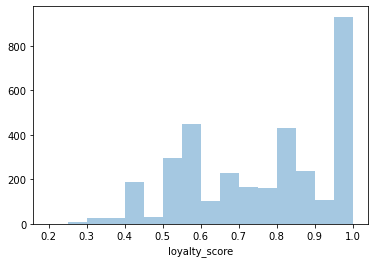

In [180]:
#Визуализируем с помощью seaborn индекс лояльности относительно количества пользователей.

ax = sns.distplot(loyalty_df.loyalty_score,kde=False)


In [181]:
# В зависимости от продуктовой задачи - мы можем менять критерий для отбора пользователей

#Если карта лояльности предполагает скидку >50% - например, отобрать тех, у кого индекс лояльности 1.0(loyal_users)

#Если небольшая массовая скидка - тогда отобрать всех пользователей, с индексом лояльности >0.7

In [208]:
#Если необходимо определить конкретный бренд, с самой высокой степенью лояльности и количеством пользователей 

#создаем серию с количеством пользователей каждого бренда и медианными индексом лояльности, затем  - визуализируем

loyalty_brands = loyalty_df.groupby('lovely_brand',as_index=False) \
    .agg({'user_id':'count', 'loyalty_score':'median'}) \
    .sort_values('loyalty_score',ascending=False) \
    .rename(columns = {'user_id':'brand_users','loyalty_score':'median_loyal_score'})

loyalty_brands

    #.rename(columns={'user_id':''})


,lovely_brand,brand_users,median_loyal_score
3,Brand_4,2041,0.818182
6,Store_Brand,715,0.750000
0,Brand_1,410,0.679487
1,Brand_2,88,0.600000
4,Brand_5,5,0.600000
2,Brand_3,115,0.500000
5,Brand_7,9,0.444444


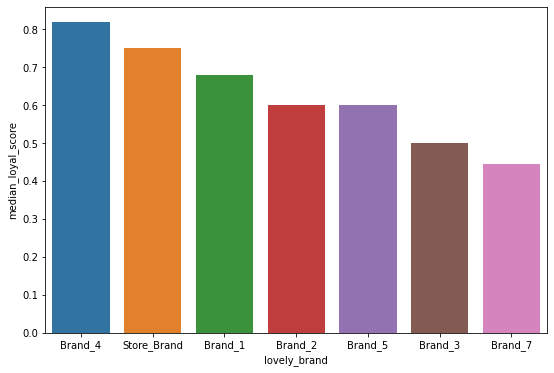

In [210]:
#Визуалиция с помощью bar plot распределение брендов, в зависимости от индекса лояльности

plt.figure(figsize=(9,6))      #для удобства - увеличим размер bar plot

ax = sns.barplot(data=loyalty_brands, x= 'lovely_brand', y= 'median_loyal_score')


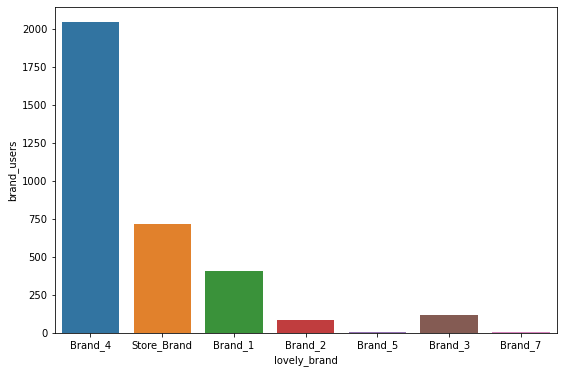

In [214]:
#Визуализируем и сохраняем гистрограмму, с наиболее популярным брендом среди лояльных(>=5 покупок) пользователей

plt.figure(figsize=(9,6))

ax = sns.barplot(data =loyalty_brands, x= 'lovely_brand', y='brand_users' )

plt.savefig('popularity of brands.jpg')


In [241]:
#Сохраняем отдельно данные по таблице 

#def file_name1(x):
    today_day = datetime.today().strftime('%y-%m-%d')
    file_name = 'loyalty_df _{}.csv'
    file_name = file_name.format(today_day)
    return x.to_csv(file_name)
